In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

=== Physics-Based Plasma Data Generator ===
Optimized for Kaggle T4 GPU environment
Generating plasma dataset...
Normal samples: 2000
Anomalous samples: 500
Base seed: 42

Generating normal plasma samples...
  Generated 200/2000 normal samples
  Generated 400/2000 normal samples
  Generated 600/2000 normal samples
  Generated 800/2000 normal samples
  Generated 1000/2000 normal samples
  Generated 1200/2000 normal samples
  Generated 1400/2000 normal samples
  Generated 1600/2000 normal samples
  Generated 1800/2000 normal samples
  Generated 2000/2000 normal samples

Generating anomalous plasma samples...
  Generated 100/500 anomalous samples
  Generated 200/500 anomalous samples
  Generated 300/500 anomalous samples
  Generated 400/500 anomalous samples
  Generated 500/500 anomalous samples

=== Dataset Quality Validation ===
Label distribution:
  Normal (0): 2000 samples (80.0%)
  Anomalous (1): 500 samples (20.0%)
Duplicate samples: 0

Statistical separation check:
  b_magnitude_me

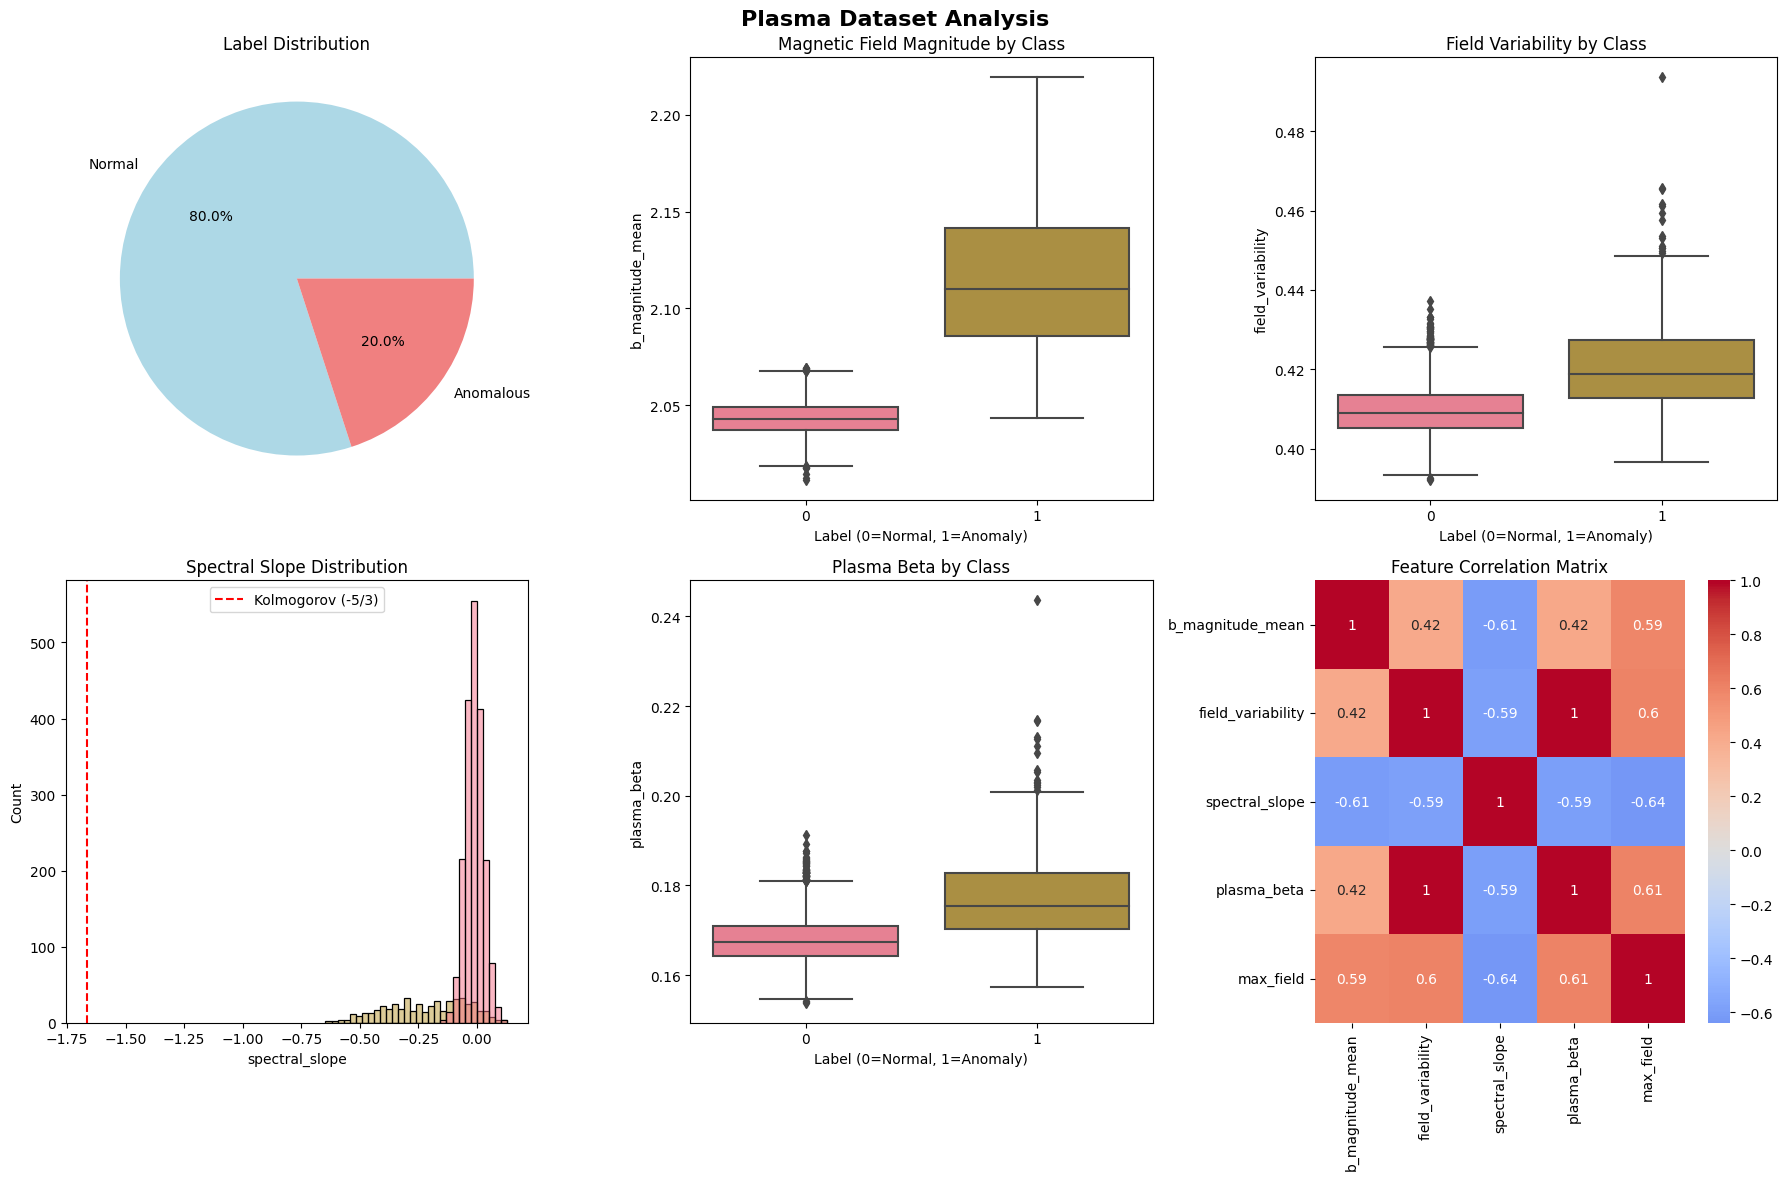


=== Dataset Summary Statistics ===

Normal samples statistics:
          b_x_mean     b_y_mean     b_z_mean      b_x_std      b_y_std  \
count  2000.000000  2000.000000  2000.000000  2000.000000  2000.000000   
mean      0.000385    -0.000350     0.000276     1.274862     1.274462   
std       0.009957     0.010078     0.009913     0.008449     0.008338   
min      -0.032870    -0.043653    -0.037226     1.249945     1.248234   
25%      -0.006476    -0.007154    -0.006326     1.268940     1.268620   
50%       0.000546    -0.000191     0.000352     1.274874     1.274321   
75%       0.006745     0.006496     0.007209     1.280631     1.279971   
max       0.032535     0.035569     0.030572     1.304567     1.302524   

           b_z_std  b_magnitude_mean  b_magnitude_std  spectral_slope  \
count  2000.000000       2000.000000      2000.000000     2000.000000   
mean      1.274747          2.043012         0.837191       -0.012007   
std       0.008314          0.009064         0.012

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal
from scipy.fft import fft, fftfreq
import os
import gc
from typing import Tuple, Dict, Any
import warnings
warnings.filterwarnings('ignore')

class PlasmaDataGenerator:
    """Physics-based plasma data generator with proper randomization"""
    
    def __init__(self, sampling_rate: int = 1000, duration: float = 10.0):
        self.sampling_rate = sampling_rate
        self.duration = duration
        self.n_samples = int(sampling_rate * duration)
        self.time = np.linspace(0, duration, self.n_samples)
        
        # Physics parameters for space plasma
        self.ion_cyclotron_freq = 0.1  # Hz
        self.electron_cyclotron_freq = 180.0  # Hz
        self.plasma_freq = 9000.0  # Hz
        self.alfven_velocity = 1000.0  # km/s
        
    def _safe_seed(self, base_seed: int) -> int:
        """Ensure seed is within numpy's valid range"""
        return int(base_seed % (2**32 - 1))
    
    def _generate_kolmogorov_spectrum(self, frequencies: np.ndarray) -> np.ndarray:
        """Generate Kolmogorov turbulence spectrum for plasma"""
        # Avoid division by zero
        f_safe = np.where(frequencies == 0, 1e-10, frequencies)
        # Kolmogorov -5/3 power law
        spectrum = f_safe**(-5/3)
        # Normalize
        spectrum = spectrum / np.max(spectrum)
        return spectrum
    
    def _inject_reconnection_event(self, signal_data: np.ndarray, start_idx: int, 
                                 duration_samples: int, intensity: float) -> np.ndarray:
        """Inject magnetic reconnection event"""
        end_idx = min(start_idx + duration_samples, len(signal_data))
        
        # Create reconnection signature: sudden field rotation + acceleration
        t_event = np.linspace(0, duration_samples/self.sampling_rate, end_idx - start_idx)
        
        # Exponential rise followed by oscillatory decay
        envelope = intensity * (1 - np.exp(-t_event * 5)) * np.exp(-t_event * 0.5)
        oscillation = np.sin(2 * np.pi * 2 * t_event) * np.cos(2 * np.pi * 0.3 * t_event)
        
        anomaly_signal = envelope * oscillation
        signal_data[start_idx:end_idx] += anomaly_signal
        
        return signal_data
    
    def _inject_plasma_instability(self, signal_data: np.ndarray, start_idx: int,
                                 duration_samples: int, mode_freq: float) -> np.ndarray:
        """Inject plasma instability (e.g., two-stream instability)"""
        end_idx = min(start_idx + duration_samples, len(signal_data))
        t_event = np.linspace(0, duration_samples/self.sampling_rate, end_idx - start_idx)
        
        # Growing oscillation with frequency chirp
        growth_rate = 2.0
        freq_chirp = mode_freq * (1 + 0.1 * t_event)
        
        instability = np.exp(growth_rate * t_event) * np.sin(2 * np.pi * freq_chirp * t_event)
        # Apply saturation
        instability = np.tanh(instability * 0.5)
        
        signal_data[start_idx:end_idx] += instability
        
        return signal_data
    
    def generate_normal_plasma(self, seed: int = None) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
        """Generate normal plasma turbulence with realistic physics"""
        if seed is not None:
            np.random.seed(self._safe_seed(seed))
        
        # Generate base turbulent field using Kolmogorov spectrum
        frequencies = fftfreq(self.n_samples, 1/self.sampling_rate)
        spectrum = self._generate_kolmogorov_spectrum(np.abs(frequencies))
        
        # Generate three components (B_x, B_y, B_z)
        b_field = np.zeros((3, self.n_samples))
        
        for i in range(3):
            # Random phases for each component
            phases = np.random.uniform(0, 2*np.pi, self.n_samples)
            complex_amplitudes = np.sqrt(spectrum) * np.exp(1j * phases)
            
            # Generate field component
            b_field[i] = np.real(np.fft.ifft(complex_amplitudes))
            
            # Add characteristic plasma frequencies
            b_field[i] += 0.1 * np.sin(2 * np.pi * self.ion_cyclotron_freq * self.time + 
                                     np.random.uniform(0, 2*np.pi))
            b_field[i] += 0.05 * np.sin(2 * np.pi * self.electron_cyclotron_freq * self.time + 
                                      np.random.uniform(0, 2*np.pi))
        
        # Add correlated noise
        noise_level = 0.1
        for i in range(3):
            b_field[i] += noise_level * np.random.normal(0, 1, self.n_samples)
        
        # Normalize to realistic field strengths (nT)
        b_field = b_field * 10  # 10 nT typical
        
        return b_field[0], b_field[1], b_field[2]
    
    def generate_anomalous_plasma(self, anomaly_type: str = 'reconnection', seed: int = None) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
        """Generate plasma with injected anomalies"""
        if seed is not None:
            np.random.seed(self._safe_seed(seed))
        
        # Start with normal plasma
        b_x, b_y, b_z = self.generate_normal_plasma(seed=self._safe_seed(seed + 1) if seed else None)
        
        # Inject anomaly
        anomaly_start = np.random.randint(int(0.2 * self.n_samples), int(0.8 * self.n_samples))
        
        if anomaly_type == 'reconnection':
            duration = np.random.randint(int(0.5 * self.sampling_rate), int(2.0 * self.sampling_rate))
            intensity = np.random.uniform(2.0, 5.0)
            
            b_x = self._inject_reconnection_event(b_x, anomaly_start, duration, intensity)
            b_y = self._inject_reconnection_event(b_y, anomaly_start, duration, intensity * 0.8)
            b_z = self._inject_reconnection_event(b_z, anomaly_start, duration, intensity * 1.2)
            
        elif anomaly_type == 'instability':
            duration = np.random.randint(int(1.0 * self.sampling_rate), int(3.0 * self.sampling_rate))
            mode_freq = np.random.uniform(5.0, 50.0)
            
            b_x = self._inject_plasma_instability(b_x, anomaly_start, duration, mode_freq)
            b_y = self._inject_plasma_instability(b_y, anomaly_start, duration, mode_freq * 1.1)
            b_z = self._inject_plasma_instability(b_z, anomaly_start, duration, mode_freq * 0.9)
        
        return b_x, b_y, b_z
    
    def calculate_plasma_metrics(self, b_x: np.ndarray, b_y: np.ndarray, b_z: np.ndarray) -> Dict[str, float]:
        """Calculate plasma physics metrics for quality validation"""
        # Magnetic field magnitude
        b_mag = np.sqrt(b_x**2 + b_y**2 + b_z**2)
        
        # Power spectral density
        freqs, psd = signal.welch(b_mag, self.sampling_rate, nperseg=min(1024, len(b_mag)//4))
        
        # Spectral slope (should be close to -5/3 for Kolmogorov)
        valid_freq_range = (freqs > 0.1) & (freqs < 100)
        if np.sum(valid_freq_range) > 10:
            log_f = np.log10(freqs[valid_freq_range])
            log_psd = np.log10(psd[valid_freq_range])
            spectral_slope = np.polyfit(log_f, log_psd, 1)[0]
        else:
            spectral_slope = -5/3
        
        # Plasma beta (approximation)
        plasma_beta = np.var(b_mag) / np.mean(b_mag)**2
        
        # Field variability
        field_variability = np.std(b_mag) / np.mean(b_mag)
        
        return {
            'mean_field': np.mean(b_mag),
            'field_std': np.std(b_mag),
            'spectral_slope': spectral_slope,
            'plasma_beta': plasma_beta,
            'field_variability': field_variability,
            'max_field': np.max(b_mag),
            'min_field': np.min(b_mag)
        }

def generate_plasma_dataset(n_normal: int = 2000, n_anomalous: int = 500, 
                          base_seed: int = 42) -> pd.DataFrame:
    """Generate complete plasma dataset with quality validation"""
    
    generator = PlasmaDataGenerator(sampling_rate=1000, duration=10.0)
    
    print(f"Generating plasma dataset...")
    print(f"Normal samples: {n_normal}")
    print(f"Anomalous samples: {n_anomalous}")
    print(f"Base seed: {base_seed}")
    
    data_records = []
    
    # Generate normal samples
    print("\nGenerating normal plasma samples...")
    for i in range(n_normal):
        if (i + 1) % 200 == 0:
            print(f"  Generated {i + 1}/{n_normal} normal samples")
        
        seed = generator._safe_seed(base_seed + i)
        b_x, b_y, b_z = generator.generate_normal_plasma(seed=seed)
        
        # Calculate metrics
        metrics = generator.calculate_plasma_metrics(b_x, b_y, b_z)
        
        # Store sample
        record = {
            'sample_id': f'normal_{i:04d}',
            'b_x_mean': np.mean(b_x),
            'b_y_mean': np.mean(b_y),
            'b_z_mean': np.mean(b_z),
            'b_x_std': np.std(b_x),
            'b_y_std': np.std(b_y),
            'b_z_std': np.std(b_z),
            'b_magnitude_mean': metrics['mean_field'],
            'b_magnitude_std': metrics['field_std'],
            'spectral_slope': metrics['spectral_slope'],
            'plasma_beta': metrics['plasma_beta'],
            'field_variability': metrics['field_variability'],
            'max_field': metrics['max_field'],
            'min_field': metrics['min_field'],
            'label': 0,  # Normal
            'anomaly_type': 'normal'
        }
        data_records.append(record)
    
    # Generate anomalous samples
    print(f"\nGenerating anomalous plasma samples...")
    anomaly_types = ['reconnection', 'instability']
    
    for i in range(n_anomalous):
        if (i + 1) % 100 == 0:
            print(f"  Generated {i + 1}/{n_anomalous} anomalous samples")
        
        # Alternate between anomaly types
        anomaly_type = anomaly_types[i % len(anomaly_types)]
        seed = generator._safe_seed(base_seed + n_normal + i)
        
        b_x, b_y, b_z = generator.generate_anomalous_plasma(anomaly_type=anomaly_type, seed=seed)
        
        # Calculate metrics
        metrics = generator.calculate_plasma_metrics(b_x, b_y, b_z)
        
        # Store sample
        record = {
            'sample_id': f'anomaly_{i:04d}',
            'b_x_mean': np.mean(b_x),
            'b_y_mean': np.mean(b_y),
            'b_z_mean': np.mean(b_z),
            'b_x_std': np.std(b_x),
            'b_y_std': np.std(b_y),
            'b_z_std': np.std(b_z),
            'b_magnitude_mean': metrics['mean_field'],
            'b_magnitude_std': metrics['field_std'],
            'spectral_slope': metrics['spectral_slope'],
            'plasma_beta': metrics['plasma_beta'],
            'field_variability': metrics['field_variability'],
            'max_field': metrics['max_field'],
            'min_field': metrics['min_field'],
            'label': 1,  # Anomalous
            'anomaly_type': anomaly_type
        }
        data_records.append(record)
    
    # Create DataFrame
    df = pd.DataFrame(data_records)
    
    # Validate dataset quality
    print(f"\n=== Dataset Quality Validation ===")
    
    # Check label distribution
    label_counts = df['label'].value_counts()
    print(f"Label distribution:")
    print(f"  Normal (0): {label_counts[0]} samples ({label_counts[0]/len(df)*100:.1f}%)")
    print(f"  Anomalous (1): {label_counts[1]} samples ({label_counts[1]/len(df)*100:.1f}%)")
    
    # Check for identical samples (data leakage)
    feature_cols = [col for col in df.columns if col not in ['sample_id', 'label', 'anomaly_type']]
    duplicates = df[feature_cols].duplicated().sum()
    print(f"Duplicate samples: {duplicates}")
    
    # Check statistical separation
    normal_data = df[df['label'] == 0][feature_cols]
    anomaly_data = df[df['label'] == 1][feature_cols]
    
    print(f"\nStatistical separation check:")
    for col in ['b_magnitude_mean', 'field_variability', 'spectral_slope']:
        normal_mean = normal_data[col].mean()
        anomaly_mean = anomaly_data[col].mean()
        normal_std = normal_data[col].std()
        anomaly_std = anomaly_data[col].std()
        
        # Cohen's d effect size
        pooled_std = np.sqrt((normal_std**2 + anomaly_std**2) / 2)
        cohens_d = abs(normal_mean - anomaly_mean) / pooled_std
        
        print(f"  {col}: Cohen's d = {cohens_d:.3f}")
    
    # Check spectral slope (should be close to Kolmogorov -5/3)
    mean_slope = df[df['label'] == 0]['spectral_slope'].mean()
    print(f"Mean spectral slope (normal): {mean_slope:.3f} (target: -1.667)")
    
    print(f"\nDataset generated successfully!")
    print(f"Total samples: {len(df)}")
    print(f"Features: {len(feature_cols)}")
    
    return df

def create_visualizations(df: pd.DataFrame):
    """Create comprehensive visualizations"""
    print("\nCreating visualizations...")
    
    # Set up the plotting style
    plt.style.use('default')
    sns.set_palette("husl")
    
    # Create figure with subplots
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('Plasma Dataset Analysis', fontsize=16, fontweight='bold')
    
    # 1. Label distribution
    label_counts = df['label'].value_counts()
    axes[0, 0].pie(label_counts.values, labels=['Normal', 'Anomalous'], autopct='%1.1f%%', 
                   colors=['lightblue', 'lightcoral'])
    axes[0, 0].set_title('Label Distribution')
    
    # 2. Field magnitude comparison
    sns.boxplot(data=df, x='label', y='b_magnitude_mean', ax=axes[0, 1])
    axes[0, 1].set_title('Magnetic Field Magnitude by Class')
    axes[0, 1].set_xlabel('Label (0=Normal, 1=Anomaly)')
    
    # 3. Field variability comparison
    sns.boxplot(data=df, x='label', y='field_variability', ax=axes[0, 2])
    axes[0, 2].set_title('Field Variability by Class')
    axes[0, 2].set_xlabel('Label (0=Normal, 1=Anomaly)')
    
    # 4. Spectral slope distribution
    sns.histplot(data=df, x='spectral_slope', hue='label', bins=30, ax=axes[1, 0])
    axes[1, 0].set_title('Spectral Slope Distribution')
    axes[1, 0].axvline(-5/3, color='red', linestyle='--', label='Kolmogorov (-5/3)')
    axes[1, 0].legend()
    
    # 5. Plasma beta comparison
    sns.boxplot(data=df, x='label', y='plasma_beta', ax=axes[1, 1])
    axes[1, 1].set_title('Plasma Beta by Class')
    axes[1, 1].set_xlabel('Label (0=Normal, 1=Anomaly)')
    
    # 6. Correlation heatmap for selected features
    feature_cols = ['b_magnitude_mean', 'field_variability', 'spectral_slope', 'plasma_beta', 'max_field']
    corr_matrix = df[feature_cols].corr()
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, ax=axes[1, 2])
    axes[1, 2].set_title('Feature Correlation Matrix')
    
    plt.tight_layout()
    plt.savefig('plasma_dataset_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Print summary statistics
    print("\n=== Dataset Summary Statistics ===")
    feature_cols = [col for col in df.columns if col not in ['sample_id', 'label', 'anomaly_type']]
    
    print("\nNormal samples statistics:")
    print(df[df['label'] == 0][feature_cols].describe())
    
    print("\nAnomalous samples statistics:")
    print(df[df['label'] == 1][feature_cols].describe())

# Main execution
if __name__ == "__main__":
    # Memory optimization for Kaggle T4
    os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
    
    print("=== Physics-Based Plasma Data Generator ===")
    print("Optimized for Kaggle T4 GPU environment")
    
    # Generate dataset
    df = generate_plasma_dataset(n_normal=2000, n_anomalous=500, base_seed=42)
    
    # Save dataset
    output_file = 'plasma_data.csv'
    df.to_csv(output_file, index=False)
    print(f"\nDataset saved to: {output_file}")
    
    # Create visualizations
    create_visualizations(df)
    
    # Memory cleanup
    gc.collect()
    
    print("\n=== Data Generation Complete ===")
    print(f"Dataset shape: {df.shape}")
    print(f"Output file: {output_file}")
    print("Ready for CNN training phase!")